In [17]:
import numpy as np
import matplotlib.pyplot as plt
import bnk

# Structure

## Cavity Structure

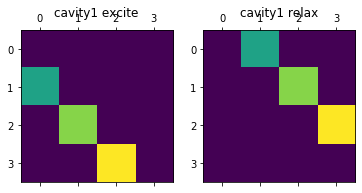

In [18]:
class Cavity(bnk.HSpace):
    def __init__(self, n=4, name='cavity'):
        super().__init__(n, name)

        excite = 0
        for i in range(1, n):
            excite_i = self.eigenstate(i) @ self.eigenstate(i - 1).ct
            excite += np.sqrt(i) * excite_i
        relax = excite.ct

        self.excite = excite
        self.relax = relax

cavity1 = Cavity(4,'cavity1')
cavity2 = Cavity(4,'cavity2')
cavity3 = Cavity(4,'cavity3')


plt.subplot(1, 2, 1)
plt.matshow(cavity1.excite.flattened_values, 0)
plt.title("cavity1 excite")

plt.subplot(1, 2, 2)
plt.matshow(cavity1.relax.flattened_values, 0)
plt.title("cavity1 relax")

plt.show()

## Sink Structure

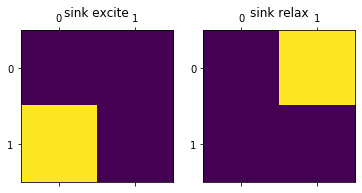

In [19]:
sink = bnk.HSpace(2,'sink')

sink_excite = sink.eigenstate(1) @ sink.eigenstate(0).ct
sink_relax = sink_excite.ct


plt.subplot(1, 2, 1)
plt.matshow(sink_excite.flattened_values, 0)
plt.title("sink excite")

plt.subplot(1, 2, 2)
plt.matshow(sink_relax.flattened_values, 0)
plt.title("sink relax")

plt.show()

# Evolution

## Hamiltonian

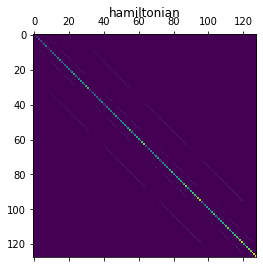

In [20]:
hb = 1
w = 1
v12 = 0.2
v23 = 0.2

energy = (0
    + cavity1.excite @ cavity1.relax
    + cavity2.excite @ cavity2.relax
    + cavity3.excite @ cavity3.relax
    + sink_excite @ sink_relax
)

interaction12 = ( 0
    + cavity1.relax @ cavity2.excite
    + cavity1.excite @ cavity2.relax
)

interaction23 = ( 0
    + cavity2.relax @ cavity3.excite
    + cavity2.excite @ cavity3.relax
)

hamiltonian = hb * w * energy+ v12 * interaction12 + v23 * interaction23


plt.matshow(hamiltonian.flattened_values)
plt.title("hamiltonian")
plt.show()

## Decoherence

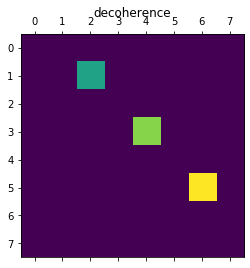

In [21]:
gamma = 0.44

decoherence = gamma * sink_excite @ cavity2.relax


plt.matshow(decoherence.flattened_values)
plt.title("decoherence")
plt.show()

# Iteration

## Initial $\rho$

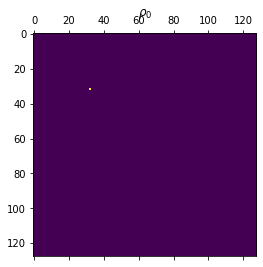

In [22]:
psi0 = \
    cavity1.eigenstate(1) @ \
    cavity2.eigenstate(0) @ \
    cavity3.eigenstate(0) @ \
    sink.eigenstate(0)

rho0 = psi0 @ psi0.ct


plt.matshow(rho0.flattened_values)
plt.title("$\\rho_0$")
plt.show()

## Configurations

In [23]:
dt = 0.005
mt = 70

dlt = mt / 100

## Iterations

In [24]:
def logger(rho):
    prob_sink = (sink.eigenstate(1).ct @ rho @ sink.eigenstate(1)).trace().values
    prob_cavity1 = (cavity1.eigenstate(1).ct @ rho @ cavity1.eigenstate(1)).trace().values
    prob_cavity2 = (cavity2.eigenstate(1).ct @ rho @ cavity2.eigenstate(1)).trace().values
    prob_cavity3 = (cavity3.eigenstate(1).ct @ rho @ cavity3.eigenstate(1)).trace().values
    return prob_sink, prob_cavity1, prob_cavity2, prob_cavity3

In [25]:
%%time

_, logs_t, logs_v = bnk.evolve_lindblad_with_logs(
    rho0, hamiltonian, decoherence, hb,
    mt, dt, dlt, logger=logger)

computing...100.00%
Wall time: 17.9 s


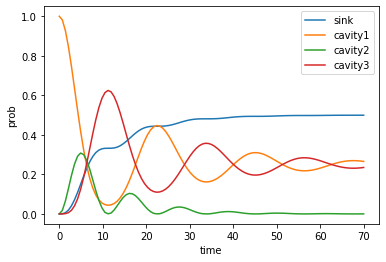

In [26]:
def plot_logs(logs_t, logs_v):
    logs_v = np.abs(logs_v)

    plt.plot(logs_t, logs_v[:,0], label='sink')
    plt.plot(logs_t, logs_v[:,1], label='cavity1')
    plt.plot(logs_t, logs_v[:,2], label='cavity2')
    plt.plot(logs_t, logs_v[:,3], label='cavity3')
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("prob")
    plt.show()

plot_logs(logs_t,logs_v)

## Reduction

In [27]:
reduced_space = bnk.ReducedHSpace.from_seed(
    [psi0],[hamiltonian, decoherence],'reduced_system')

print([dim.name for dim in reduced_space.org_eigenstates[0].dims])
for i, org_eigenstate in enumerate(reduced_space.org_eigenstates):
    code = list(np.transpose(np.where(org_eigenstate.values))[0])
    print(i, code)

['cavity1', 'cavity2', 'cavity3', 'sink']
0 [0, 0, 0, 1]
1 [0, 0, 1, 0]
2 [0, 1, 0, 0]
3 [1, 0, 0, 0]


<Figure size 432x288 with 0 Axes>

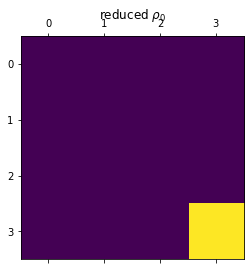

<Figure size 432x288 with 0 Axes>

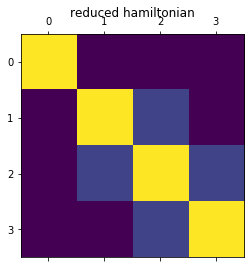

In [28]:
reduced_rho0 = reduced_space.reduce(rho0)
reduced_hamiltonian = reduced_space.reduce(hamiltonian)
reduced_decoherence = reduced_space.reduce(decoherence)


plt.figure()
plt.matshow(reduced_rho0.flattened_values)
plt.title("reduced $\\rho_0$")

plt.figure()
plt.matshow(reduced_hamiltonian.flattened_values)
plt.title("reduced hamiltonian")

plt.show()

## Iterations (reduced)

In [29]:
def logger_reduced(rho):
    rho = reduced_space.inflate(rho)
    prob_sink = (sink.eigenstate(1).ct @ rho @ sink.eigenstate(1)).trace().values
    prob_cavity1 = (cavity1.eigenstate(1).ct @ rho @ cavity1.eigenstate(1)).trace().values
    prob_cavity2 = (cavity2.eigenstate(1).ct @ rho @ cavity2.eigenstate(1)).trace().values
    prob_cavity3 = (cavity3.eigenstate(1).ct @ rho @ cavity3.eigenstate(1)).trace().values
    return prob_sink, prob_cavity1, prob_cavity2, prob_cavity3

In [30]:
%%time

_, logs_t, logs_v = bnk.evolve_lindblad_with_logs(
    reduced_rho0, reduced_hamiltonian, reduced_decoherence, hb,
    mt, dt, dlt,
    logger=logger_reduced)

computing...100.00%
Wall time: 776 ms


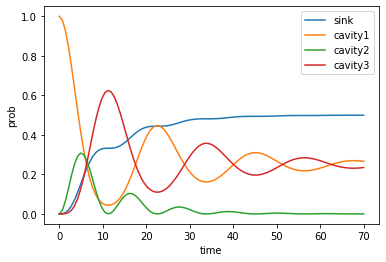

In [31]:
plot_logs(logs_t,logs_v)